## Dataset

### Load dataset from Kaggle (uncomment if needed)

In [1]:
# !mkdir -p /root/.kaggle/
# !echo '{"username":"tibid94554sha","key":"57419f0675a80ab30fa664dc16a396bb"}' > /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [2]:
# !kaggle competitions download -c vehicle

In [3]:
# !unzip -qq vehicle.zip

### Load dataset from Google Drive (uncomment if needed)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp /content/drive/MyDrive/vehicle.zip /content/vehicle.zip

In [6]:
# !unzip -qq vehicle.zip

### Save dataset to Google Drive (uncomment if needed)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# !cp /content/vehicle.zip /content/drive/MyDrive/vehicle.zip

### Check dataset exists

In [9]:
import os

# Путь к директории верхнего уровня
base_dir = 'train/train'

# Проверяем, существует ли директория
if not os.path.exists(base_dir):
    print(f"Директория {base_dir} не существует.")
else:
    # Получаем список всех объектов в директории
    subdirectories = os.listdir(base_dir)

    # Флаг для отслеживания наличия хотя бы одной непустой поддиректории
    found_non_empty = False

    for subdir in subdirectories:
        subdir_path = os.path.join(base_dir, subdir)

        # Проверяем, является ли объект директорией
        if os.path.isdir(subdir_path):
            # Проверяем, не пуста ли директория
            if not os.listdir(subdir_path):
                print(f"Директория {subdir_path} пуста.")
            else:
                print(f"В директории {subdir_path} есть файлы.")
                found_non_empty = True
        else:
            print(f"{subdir_path} не является директорией.")

    if not found_non_empty:
        print("Не найдены непустые поддиректории.")
        assert False


В директории train/train/Ambulance есть файлы.
В директории train/train/Barge есть файлы.
В директории train/train/Bicycle есть файлы.
В директории train/train/Boat есть файлы.
В директории train/train/Bus есть файлы.
В директории train/train/Car есть файлы.
В директории train/train/Cart есть файлы.
В директории train/train/Caterpillar есть файлы.
В директории train/train/Helicopter есть файлы.
В директории train/train/Limousine есть файлы.
В директории train/train/Motorcycle есть файлы.
В директории train/train/Segway есть файлы.
В директории train/train/Snowmobile есть файлы.
В директории train/train/Tank есть файлы.
В директории train/train/Taxi есть файлы.
В директории train/train/Truck есть файлы.
В директории train/train/Van есть файлы.


## Base imports

In [10]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pywt
from PIL import Image

## Read data

In [11]:
import os

root_train = './train/train/'

data_train = []

for category in sorted(os.listdir(root_train)):
    for file in sorted(os.listdir(os.path.join(root_train, category))):
        data_train.append((category, os.path.join(root_train, category, file)))

print(f'Train data: {len(data_train)}')

Train data: 28045


## Create data frame

In [12]:
from sklearn.preprocessing import LabelEncoder

src_df = pd.DataFrame(data_train, columns=['class','file_path'])

src_df.head()

,class,file_path
0,Ambulance,./train/train/Ambulance/000040_09.jpg
1,Ambulance,./train/train/Ambulance/000050_10.jpg
2,Ambulance,./train/train/Ambulance/000052_03.jpg
3,Ambulance,./train/train/Ambulance/000057_04.jpg
4,Ambulance,./train/train/Ambulance/000067_14.jpg


## Decrease data frame

In [13]:
CLASSES = src_df['class'].unique()
IMAGES_PER_CLASS = 50

In [14]:
def subset_classes(data, classes, max_per_class):
    result_df = pd.DataFrame()
    for cls in classes:
        class_subset = data[data['class'] == cls].head(max_per_class)
        result_df = pd.concat([result_df, class_subset])

    return result_df

df = subset_classes(src_df, CLASSES, IMAGES_PER_CLASS)
df.head()

,class,file_path
0,Ambulance,./train/train/Ambulance/000040_09.jpg
1,Ambulance,./train/train/Ambulance/000050_10.jpg
2,Ambulance,./train/train/Ambulance/000052_03.jpg
3,Ambulance,./train/train/Ambulance/000057_04.jpg
4,Ambulance,./train/train/Ambulance/000067_14.jpg


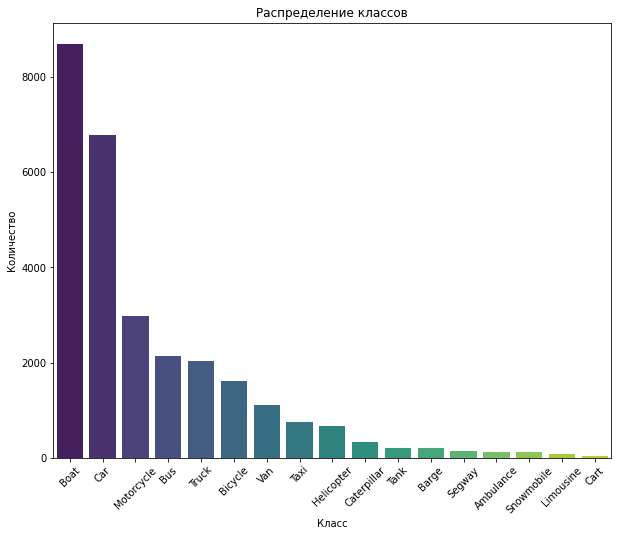

In [15]:
# распределение классов
class_distribution = src_df['class'].value_counts()  # Подсчет количества каждого класса
plt.figure(figsize=(10, 8))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Распределение классов')
plt.ylabel('Количество')
plt.xlabel('Класс')
plt.xticks(rotation=45)
plt.show()

In [16]:
def get_image_size(image):
    return image.size

def calculate_brightness(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return np.mean(image)

def calculate_contrast(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return image.std()

def get_colorfulness(image):
    image = np.array(image)
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    std_rg_yb = np.sqrt(np.std(rg) ** 2 + np.std(yb) ** 2)
    mean_rg_yb = np.sqrt(np.mean(rg) ** 2 + np.mean(yb) ** 2)
    return std_rg_yb + (0.3 * mean_rg_yb)

def wavelet_transform(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA, cH, cV, cD

file_path_to_data = {}

for i, file_path in enumerate(df['file_path']):
    with Image.open(file_path) as img:
        file_path_to_data[file_path] = {
            'size': get_image_size(img),
            'brightness': calculate_brightness(img),
            'contrast': calculate_contrast(img),
            'colorfulness': get_colorfulness(img),
            'wavelet': wavelet_transform(img),
        }
    
    if i % 100 == 0:
        print('Processed: ', i)


Processed:  0
Processed:  100
Processed:  200
Processed:  300
Processed:  400
Processed:  500
Processed:  600
Processed:  700
Processed:  800


In [17]:
df['width'] = df['file_path'].apply(lambda x: file_path_to_data[x]['size'][0])
df['height'] = df['file_path'].apply(lambda x: file_path_to_data[x]['size'][1])
df['brightness'] = df['file_path'].apply(lambda x: file_path_to_data[x]['brightness'])
df['contrast'] = df['file_path'].apply(lambda x: file_path_to_data[x]['contrast'])
df['colorfulness'] = df['file_path'].apply(lambda x: file_path_to_data[x]['colorfulness'])

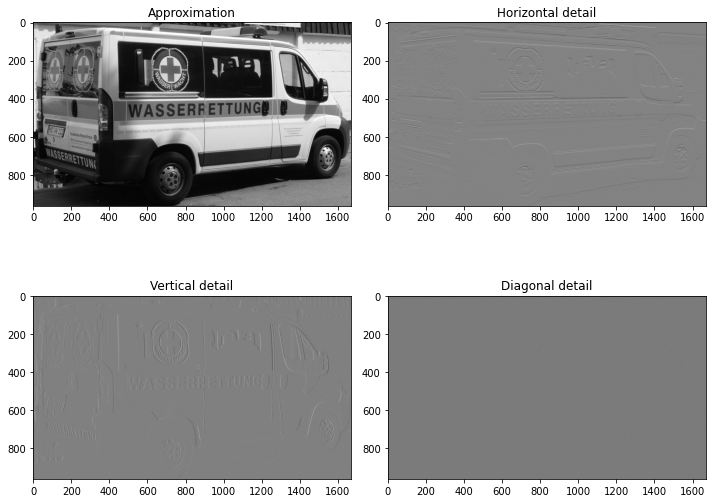

In [18]:
# Пример для одного изображения
image = Image.open(df.iloc[5]['file_path']).convert('L')
cA, cH, cV, cD = wavelet_transform(np.array(image))
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(cA, cmap='gray')
plt.title('Approximation')
plt.subplot(2, 2, 2)
plt.imshow(cH, cmap='gray')
plt.title('Horizontal detail')
plt.subplot(2, 2, 3)
plt.imshow(cV, cmap='gray')
plt.title('Vertical detail')
plt.subplot(2, 2, 4)
plt.imshow(cD, cmap='gray')
plt.title('Diagonal detail')
plt.tight_layout()
plt.show()


In [19]:
# Агрегацию по классам можно выполнить так:
grouped = df.groupby('class').agg({
    'brightness': ['mean', 'std'],
    'contrast': ['mean', 'std'],
    'colorfulness': ['mean', 'std'],
    'width': ['mean', 'std'],
    'height': ['mean', 'std']
}).reset_index()
grouped.columns = ['class', 'brightness_mean', 'brightness_std', 'contrast_mean', 'contrast_std', 'colorfulness_mean', 'colorfulness_std', 'width_mean', 'width_std', 'height_mean', 'height_std']

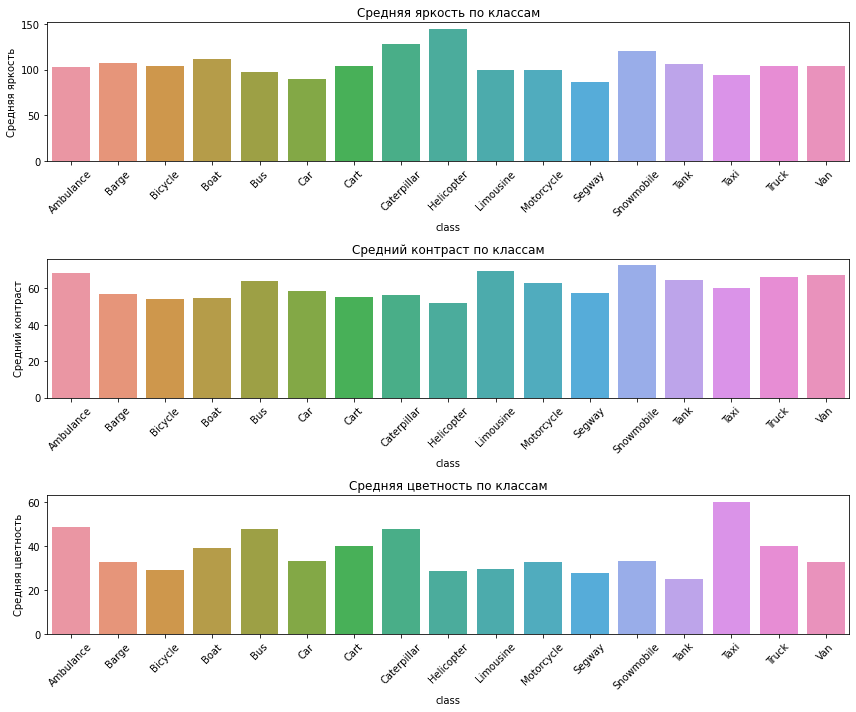

In [20]:
plt.figure(figsize=(12, 10))

# Яркость
plt.subplot(3, 1, 1)
sns.barplot(x='class', y='brightness_mean', data=grouped)
plt.title('Средняя яркость по классам')
plt.ylabel('Средняя яркость')
plt.xticks(rotation=45)

# Контраст
plt.subplot(3, 1, 2)
sns.barplot(x='class', y='contrast_mean', data=grouped)
plt.title('Средний контраст по классам')
plt.ylabel('Средний контраст')
plt.xticks(rotation=45)

# Цветность
plt.subplot(3, 1, 3)
sns.barplot(x='class', y='colorfulness_mean', data=grouped)
plt.title('Средняя цветность по классам')
plt.ylabel('Средняя цветность')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


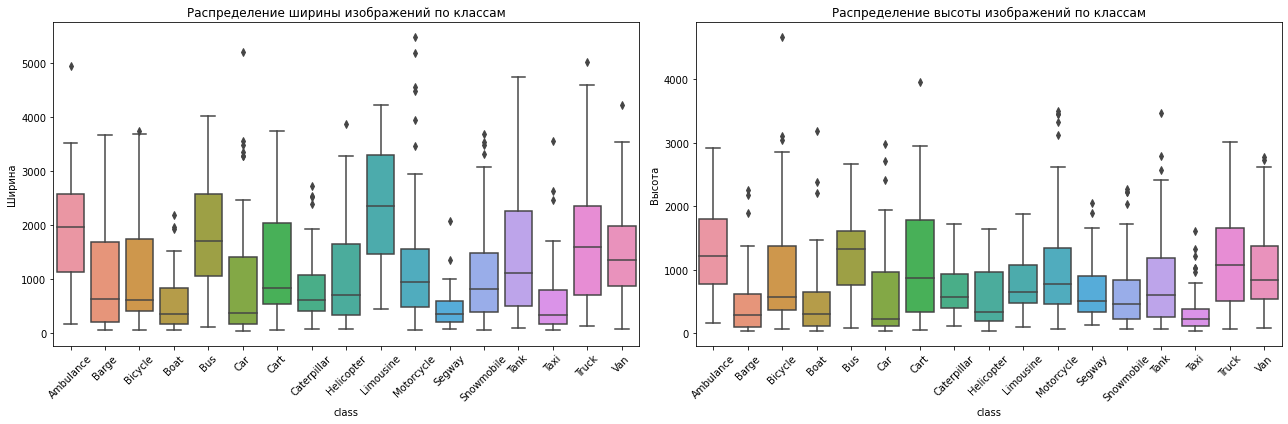

In [21]:
plt.figure(figsize=(18, 6))

# Ширина
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='width', data=df)
plt.title('Распределение ширины изображений по классам')
plt.ylabel('Ширина')
plt.xticks(rotation=45)

# Высота
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='height', data=df)
plt.title('Распределение высоты изображений по классам')
plt.ylabel('Высота')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Example image

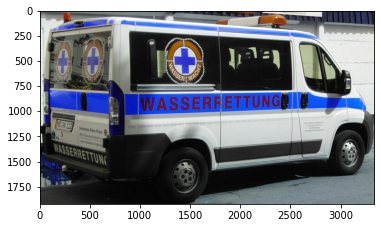

In [22]:
example_file_path = data_train[5][1]

img = cv2.imread(example_file_path)
plt.imshow(img)

### Wavelet transform

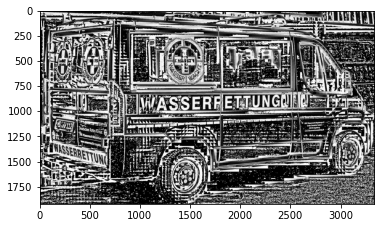

In [23]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img

    # Datatype conversions
    # convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)

    # convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;

    # compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    # Process Coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


im_har = w2d(img, 'db1', 5)
plt.imshow(im_har, cmap='gray')